# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Project Goal

The goal of this project is to build a machine learning model that predicts whether or not someone will respond to an offer. To do this, i will take the following steps.
1. Carry out exploratory data analysis to determine how much people respond to starbucks offer based on the type of offer, the reward, the medium through which they received the offer and other metrics present in the dataset.
2. Clean the data, then build a machine learning model to predict the probability of the customer responding to the offer.

In [1]:
# import libraries
import math
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline
sns.set()

In [2]:
# read in the json files
portfolio = pd.read_json('../input/starbucks-app-customer-reward-program-data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../input/starbucks-app-customer-reward-program-data/profile.json', orient='records', lines=True)
transcript = pd.read_json('../input/starbucks-app-customer-reward-program-data/transcript.json', orient='records', lines=True)

### Initial Analysis and Data Cleaning

In this section, i will investigate the individual dataset for any abnormalities and perform necessary cleaning steps.

#### Portfolio Dataset

**Cleaning**

In [3]:
print('Shape:',portfolio.shape)
portfolio

Shape: (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# create dummy variables for the channels column and drop it from the portfolio dataframe
portfolio[['email', 'web', 'mobile', 'social']] = 0
def dummyfy(idx, row):
    for val in row:
        portfolio.loc[idx, val] = 1
for i, row in enumerate(portfolio.channels):
    dummyfy(i, row)
    
portfolio.drop('channels', inplace=True, axis=1)
portfolio

,reward,difficulty,duration,offer_type,id,email,web,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,0,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   difficulty  10 non-null     int64 
 2   duration    10 non-null     int64 
 3   offer_type  10 non-null     object
 4   id          10 non-null     object
 5   email       10 non-null     int64 
 6   web         10 non-null     int64 
 7   mobile      10 non-null     int64 
 8   social      10 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 848.0+ bytes


**EDA**

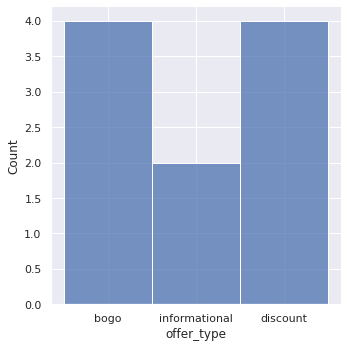

In [6]:
# view the distribution of offer type in the dataset
sns.displot(portfolio.offer_type);

#### Profile Dataset

**Cleaning**

In [7]:
print('Shape:',profile.shape)
profile.head()

Shape: (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [10]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

**Fill in the missing gender values with 'O' to represent other and the missing income values with the mean income.**

In [11]:
profile.gender.fillna('O', inplace=True)

mean_income=round(profile.income.mean(skipna=True))
profile.income.fillna(mean_income, inplace=True)

profile.head()

,gender,age,id,became_member_on,income
0,O,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,65405.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,O,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,65405.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,O,118,a03223e636434f42ac4c3df47e8bac43,20170804,65405.0


In [12]:
# Check
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

**Convert the `became_member_on` column to datetime data type**

In [13]:
profile.became_member_on=pd.to_datetime(profile.became_member_on, format='%Y%m%d')

In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            17000 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            17000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


In [15]:
profile.head()

,gender,age,id,became_member_on,income
0,O,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65405.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,O,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65405.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,O,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65405.0


#### check for outlier values

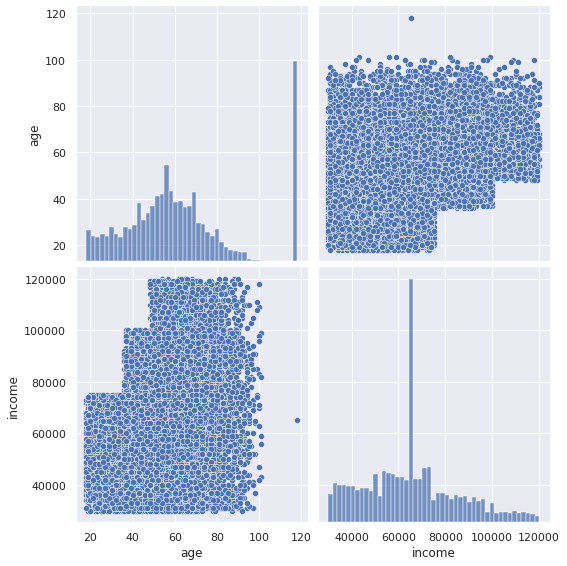

In [16]:
grid=sns.pairplot(profile, height=4)

There seems to be some outlier age values.

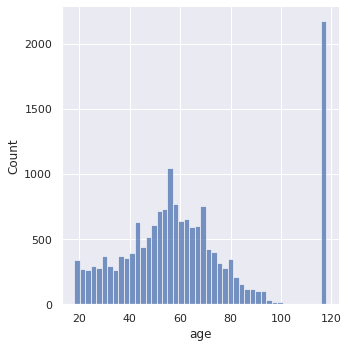

In [17]:
sns.displot(profile.age)

**remove any age values greater than 100 from the dataset**

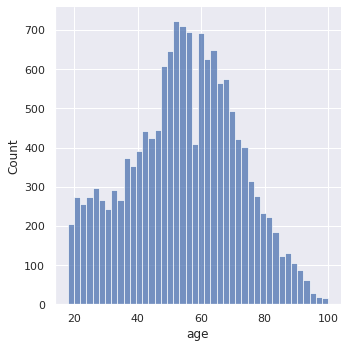

In [18]:
profile.drop(profile[profile.age > 100].index, axis=0, inplace=True)
sns.displot(profile.age);

There are no outlier income values

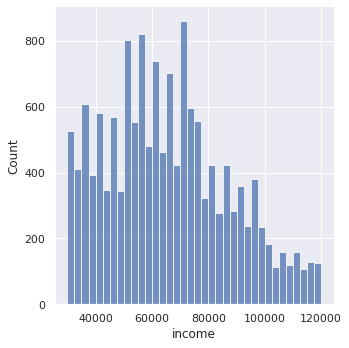

In [19]:
sns.displot(profile.income);

**EDA**

Gender distribution

There are more males in this dataset than there are females.

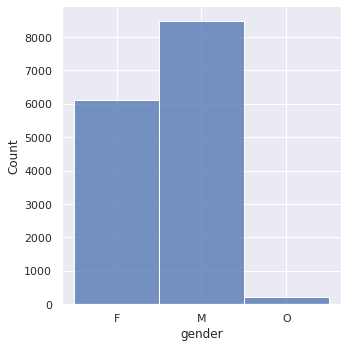

In [20]:
sns.displot(profile.gender, height=5);

#### Transcript Dataset

**Cleaning**

In [21]:
print('Shape:',transcript.shape)
transcript.head()

Shape: (306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


**Split the value column into different part based on the key**

In [22]:
# display the unique keys in the dataset
set([list(v.keys())[0] for v in transcript.value])

{'amount', 'offer id', 'offer_id'}

In [23]:
# get a list of keys and value in the value column of the transcript dataset
key=[list(v.keys())[0] for v in transcript.value]
val=[list(v.values())[0] for v in transcript.value]

# rename offer id to offer_id
key_ren = [v.replace(' ', '_') if v=='offer id' else v for v in key]

# create a list of offer ids and amounts
cat_val = zip(key_ren, val)
offer_ids = []
amounts = []

for pair in cat_val:
    if pair[0] == 'offer_id':
        offer_ids.append(pair[1])
        amounts.append(0)
    else:
        offer_ids.append('No Offer')
        amounts.append(pair[1])
        
# add the offer id and amounts column to the transcript dataset
transcript['offer_id']=offer_ids
transcript['amount']=amounts

# drop the value column from the transcript dataset
transcript.drop('value', axis=1, inplace=True)

transcript.tail(80)

,person,event,time,offer_id,amount
306454,f3e801caeafe4899b3b989b586e74ac7,transaction,714,No Offer,16.03
306455,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
306456,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
306457,dbe4489958bb4e35bcc40fa6e2bc9788,transaction,714,No Offer,20.81
306458,60f9f0df41b544a5b243952d8a89541c,transaction,714,No Offer,0.64
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,No Offer,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,No Offer,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,No Offer,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,No Offer,3.53


**EDA**

What is the distribution of transcript event?

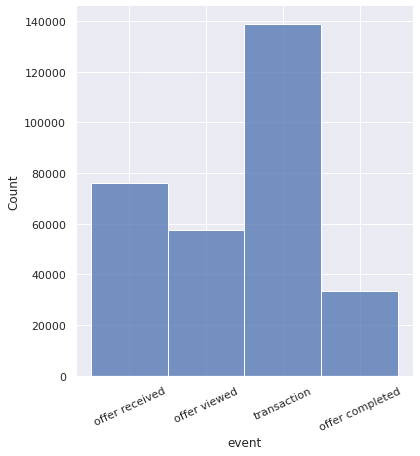

In [24]:
sns.displot(transcript.event, height=6)
plt.xticks(rotation=25);

There are more transaction order completed withoutany offer, and most offer sent were never completed even when viewed this might be due to a variety of reasons such as the offer not being interesting to the customer.

## Analysis

In this section, i will merge the three dataset and carry out more deeper analysis by answering the following questions in relation to the event that whether an offer is completed or not.
1. What is the event distribution by gender and age?
2. What is the income level of people who completed the offer and those who do not?
3. How does reward, difficlty, duration and offer type affects the event outcome?
4. Do recent customers complete more offer than older customers?

In [25]:
# join the 3 dataset into one using inner join to get only those offer transcript present in the perseon and portfolio dataframe
starbucks_df = transcript.merge(profile, left_on='person', right_on='id').merge(portfolio, left_on='offer_id', right_on='id')
starbucks_df.head()

,person,event,time,offer_id,amount,gender,age,id_x,became_member_on,income,reward,difficulty,duration,offer_type,id_y,email,web,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0


In [26]:
# drop columns not relevant to the analysis
starbucks_df=starbucks_df.drop(['person', 'offer_id', 'id_x', 'id_y', 'amount', 'time'], axis=1)
starbucks_df.head()

,event,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,web,mobile,social
0,offer received,F,75,2017-05-09,100000.0,5,5,7,bogo,1,1,1,0
1,offer viewed,F,75,2017-05-09,100000.0,5,5,7,bogo,1,1,1,0
2,offer completed,F,75,2017-05-09,100000.0,5,5,7,bogo,1,1,1,0
3,offer received,M,68,2018-04-26,70000.0,5,5,7,bogo,1,1,1,0
4,offer viewed,M,68,2018-04-26,70000.0,5,5,7,bogo,1,1,1,0


**Q1: What is the event distribution by gender and age?**

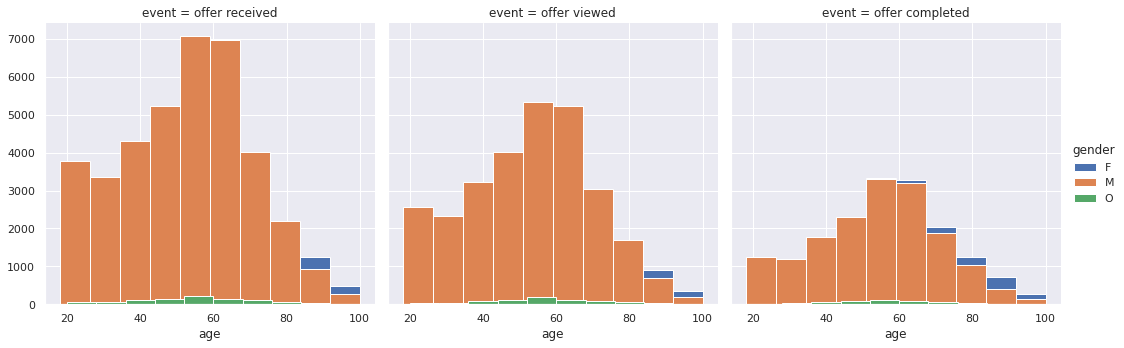

In [27]:
grid= sns.FacetGrid(starbucks_df, col='event', hue='gender', height=5)
grid.map(plt.hist, 'age').add_legend();

There are two things to notice from the plot above
1. Most of the sent offers are to the male gender
2. Most of the offers completed or not completed are from those between the age of 40 to 80 years.

**Q2: What is the income level of people who completed the offer and those who do not?**

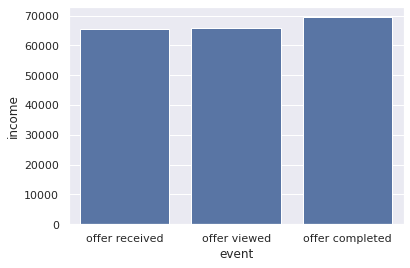

In [28]:
sns.barplot(data=starbucks_df, x='event', y='income', color=sns.color_palette()[0], ci=0);

The completed offers are from those with higher income levels.

**Q3: How does reward, difficulty, duration and offer type affects the event outcome?**

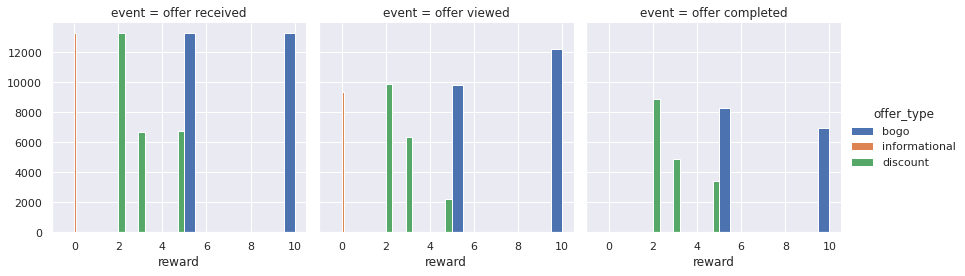

In [29]:
grid=sns.FacetGrid(starbucks_df, col='event', hue='offer_type', height=4)
grid.map(plt.hist, 'reward').add_legend();

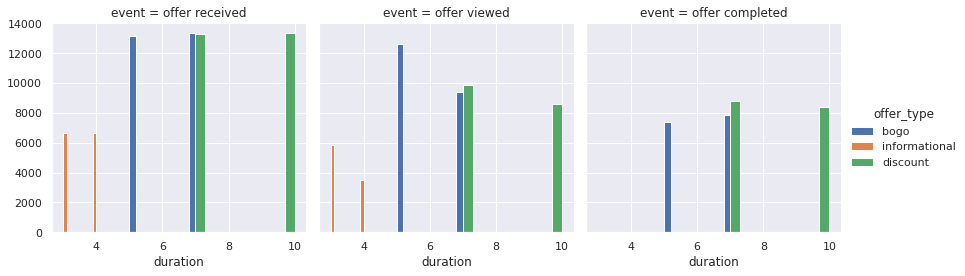

In [30]:
grid=sns.FacetGrid(starbucks_df, col='event', hue='offer_type', height=4)
grid.map(plt.hist, 'duration').add_legend();

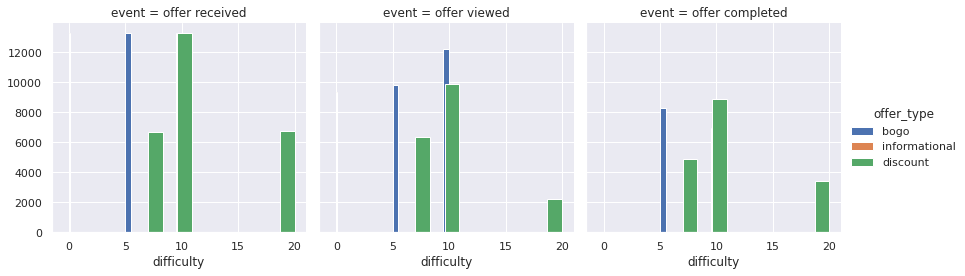

In [31]:
grid=sns.FacetGrid(starbucks_df, col='event', hue='offer_type', height=4)
grid.map(plt.hist, 'difficulty').add_legend();

Keeping in mind that there are more incomplete offer in this dataset than there are complete offers, we can notice the following about the completed offers from the above three plots.
1. Most completed bogo offer are ones with reward between 4 and 6, duration between 5 and 7 and difficulty less than 10.
2. Most completed discount offers are ones with reward between 2 and 6, duration between 6 and 10 and difficulty greater than 10.
3. There are no completed informational offer and this is to be expected as the offer exist to provide 
   information and are not meant to be completed hence they do not show up in the difficulty plot.

**Q4: Do recent customers complete more offer than older customers?**

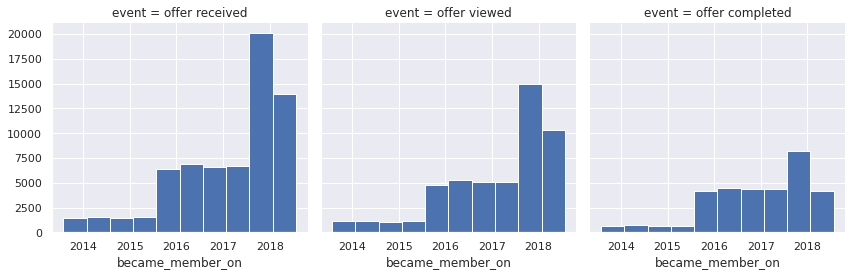

In [32]:
grid=sns.FacetGrid(data=starbucks_df, col='event', height=4)
grid.map(plt.hist, 'became_member_on');

Most completed offers are from offers sent to customers who joined between the year 2016 and 2018 though the same is true for the uncompleted offers but what this shows is that most offers are sent to customers who joined between the last two years.

### Modelling

In this section, i will be preparing the dataset for machine learning. Some of the steps that will be taken includes
1. Identify and clean the target variable.
2. Encode the categorical predictor variables.
3. Use the insights gained from the analysis to select the data that will be used for the machine learning model.

In [33]:
# print the dataframe again for easy assess
starbucks_df.head()

,event,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,web,mobile,social
0,offer received,F,75,2017-05-09,100000.0,5,5,7,bogo,1,1,1,0
1,offer viewed,F,75,2017-05-09,100000.0,5,5,7,bogo,1,1,1,0
2,offer completed,F,75,2017-05-09,100000.0,5,5,7,bogo,1,1,1,0
3,offer received,M,68,2018-04-26,70000.0,5,5,7,bogo,1,1,1,0
4,offer viewed,M,68,2018-04-26,70000.0,5,5,7,bogo,1,1,1,0


In [34]:
# check for null values
starbucks_df.isna().sum()

event               0
gender              0
age                 0
became_member_on    0
income              0
reward              0
difficulty          0
duration            0
offer_type          0
email               0
web                 0
mobile              0
social              0
dtype: int64

As the goal of this project is to predict whether a customer responds to an offer or not, this means the target variable is the `event column` of the `starbucks_df`. Investigating this column below, we now see that we only have three possible outcomes after merging the 3 dataset as the transaction events (**purchase withotut offers**) have been removed from the dataframe.

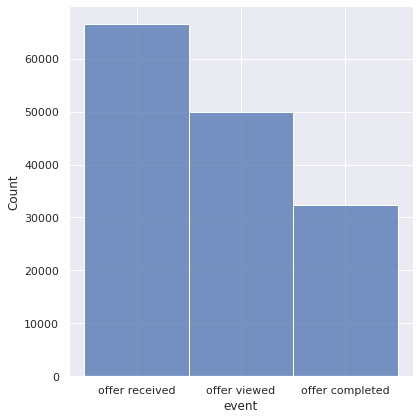

In [35]:
sns.displot(data=starbucks_df, x='event', height=6);

I will reduce this to only two categories, **completed**(1) and not **completed**(0)

In [36]:
starbucks_df.event=starbucks_df.event.apply(lambda x: 1 if x == 'offer completed' else 2)

In [37]:
# check
starbucks_df.event.value_counts()

2    116322
1     32432
Name: event, dtype: int64

In [38]:
# extract year and month from the became_memeber_on date column
# source: https://stackoverflow.com/questions/13648774/get-year-month-or-day-from-numpy-datetime64
dates=starbucks_df['became_member_on'].values

years = dates.astype('datetime64[Y]').astype(int) + 1970
months = dates.astype('datetime64[M]').astype(int) % 12 + 1

In [39]:
starbucks_df['year'] = years
starbucks_df['month']=months

In [40]:
# drop the became_member_on column
starbucks_df.drop('became_member_on', axis=1, inplace=True)

In [41]:
starbucks_df.gender.value_counts()

M    82896
F    63668
O     2190
Name: gender, dtype: int64

In [42]:
# onehot encode the gender column
def encode_gender(x):
    if x == 'M':
        return 1
    elif x == 'F':
        return 2
    else:
        return 3
        
starbucks_df.gender = starbucks_df.gender.apply(encode_gender)

In [43]:
# check
starbucks_df.gender.value_counts()

1    82896
2    63668
3     2190
Name: gender, dtype: int64

It seems that informational offer are not meant to be completed as seen from the analysis, so we can safely drop them from the dataset to fed into the machine learning model.

In [44]:
# drop the informational offer type
starbucks_df.drop(starbucks_df[starbucks_df.offer_type=='informational'].index, inplace=True)

In [45]:
starbucks_df.offer_type.value_counts()

bogo        63828
discount    62278
Name: offer_type, dtype: int64

In [46]:
# encode the offer type column
starbucks_df.offer_type=starbucks_df.offer_type.apply(lambda x: 1 if x=='bogo' else 2)

In [47]:
# check
starbucks_df.head()

,event,gender,age,income,reward,difficulty,duration,offer_type,email,web,mobile,social,year,month
0,2,2,75,100000.0,5,5,7,1,1,1,1,0,2017,5
1,2,2,75,100000.0,5,5,7,1,1,1,1,0,2017,5
2,1,2,75,100000.0,5,5,7,1,1,1,1,0,2017,5
3,2,1,68,70000.0,5,5,7,1,1,1,1,0,2018,4
4,2,1,68,70000.0,5,5,7,1,1,1,1,0,2018,4


In [48]:
# split the target variable from the predictor variable
X, y = starbucks_df.drop('event', axis=1), starbucks_df.event

# split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
# check
print(y)
X.head()

0         2
1         2
2         1
3         2
4         2
         ..
148749    2
148750    2
148751    2
148752    2
148753    2
Name: event, Length: 126106, dtype: int64


,gender,age,income,reward,difficulty,duration,offer_type,email,web,mobile,social,year,month
0,2,75,100000.0,5,5,7,1,1,1,1,0,2017,5
1,2,75,100000.0,5,5,7,1,1,1,1,0,2017,5
2,2,75,100000.0,5,5,7,1,1,1,1,0,2017,5
3,1,68,70000.0,5,5,7,1,1,1,1,0,2018,4
4,1,68,70000.0,5,5,7,1,1,1,1,0,2018,4


In [50]:
# create and fit the models
# base model
base_model=GaussianNB()
base_model.fit(X_train, y_train)

# Random forest model
model_rf=RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Gradient Boosting model
model_grad=GradientBoostingClassifier(random_state=42)
model_grad.fit(X_train, y_train)

# KNeighbours model
model_knn=KNeighborsClassifier()
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [51]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Takes a fitted the model and evaluates its prediction on the
    training and test data using accuracy score and classification report
    
    Input
    -----
    model: the fittes model to be evaluated
    X_train: the training predictor dataset
    y_train: the training response dataset
    X_test: the test predictor dataset
    y_test: the test response dataset
    
    Output
    -------
    
    """
    
    train_pred=model.predict(X_train)
    test_pred=model.predict(X_test)
    
    train_report=classification_report(y_train, train_pred)
    test_report=classification_report(y_test, test_pred)
    
#     train_report_df = pd.DataFrame(train_report)
#     test_report_df = pd.DataFrame(test_report)
    
    return train_report, test_report

In [52]:
def print_report(models, X_train, y_train, X_test, y_test):
    """
    prints the classification report for all the models passed in
    
    Input
    -----
    models: list of fitted models
    """
    for model in models:
        train_report, test_report=evaluate_model(model, X_train, y_train, X_test, y_test)
        print(model.__class__.__name__)
        print('-'*20)
        print('Train Report')
        print(train_report)
        print('Test Report')
        print(test_report)
        print('-'*20)
        print()

In [53]:
models=[base_model, model_rf, model_grad, model_knn]
print_report(models, X_train, y_train, X_test, y_test)

GaussianNB
--------------------
Train Report
              precision    recall  f1-score   support

           1       0.34      0.00      0.00     22753
           2       0.74      1.00      0.85     65521

    accuracy                           0.74     88274
   macro avg       0.54      0.50      0.43     88274
weighted avg       0.64      0.74      0.63     88274

Test Report
              precision    recall  f1-score   support

           1       0.59      0.00      0.00      9679
           2       0.74      1.00      0.85     28153

    accuracy                           0.74     37832
   macro avg       0.67      0.50      0.43     37832
weighted avg       0.71      0.74      0.64     37832

--------------------

RandomForestClassifier
--------------------
Train Report
              precision    recall  f1-score   support

           1       0.66      0.21      0.32     22753
           2       0.78      0.96      0.86     65521

    accuracy                           0.77   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classificat

GradientBoostingClassifier
--------------------
Train Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     22753
           2       0.74      1.00      0.85     65521

    accuracy                           0.74     88274
   macro avg       0.37      0.50      0.43     88274
weighted avg       0.55      0.74      0.63     88274

Test Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      9679
           2       0.74      1.00      0.85     28153

    accuracy                           0.74     37832
   macro avg       0.37      0.50      0.43     37832
weighted avg       0.55      0.74      0.64     37832

--------------------

KNeighborsClassifier
--------------------
Train Report
              precision    recall  f1-score   support

           1       0.54      0.10      0.17     22753
           2       0.76      0.97      0.85     65521

    accuracy                    

### Metrics justification

I choose to use the classification report to ouput all metrics usually considered during a classification evaluation for the following reasons

1. It reports the Accuracy which show many of the how close our predictions are to the true value
2. It reports the precision which tells us how many of our predictions are actually correct predictions and recall which tells how many of the true predictions we correctly predicted.
3. It report the F1 score which gives the harmonic mean of both the precision and recall.
4. It shows the number of observation supporting the predictions of each predicted response.

### Observations

From the analysis, it was noticed that there are more uncompleted offers in this dataset than there are completed offers, and it shows in the model predictions as the predictions are mostly for the case where the offer was not completed. Plotting the confusion matrix below supports this observation.

In [54]:
# reference: https://datatofish.com/confusion-matrix-python/#:~:
# text=confusion_matrix%20%3D%20pd.crosstab%20%28df%20%5B%27y_Actual%27%5D%2C%20df%20%5B%27y_Predicted%27%5D%2C%20rownames%3D,
# full%20Python%20code%20to%20create%20the%20Confusion%20Matrix%3A

def plot_confusion(models, X_test, y_test, size=(25,6)):
    """
    Plots the confusion matrix for the model predictions
    
    Input
    -----
    models: list of fitted models
    X_test: the test predictor dataset
    y_test: the test response dataset
    
    Output
    -------
    Heatmap plots of the confusion matrix
    """
    fig, ax = plt.subplots(1,len(models), figsize=size)
    for i, model in enumerate(models):
        data = {'y_Actual':    y_test,
            'y_Predicted': model.predict(X_test)
            }

        df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
        confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
        try:
            ax[i].set_title(model.__class__.__name__)
            sns.heatmap(confusion_matrix, annot=True, ax=ax[i], cmap='viridis_r', fmt='d', linewidths=.5)
        except:
            ax.set_title(model.__class__.__name__)
            sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='viridis_r', fmt='d', linewidths=.5)

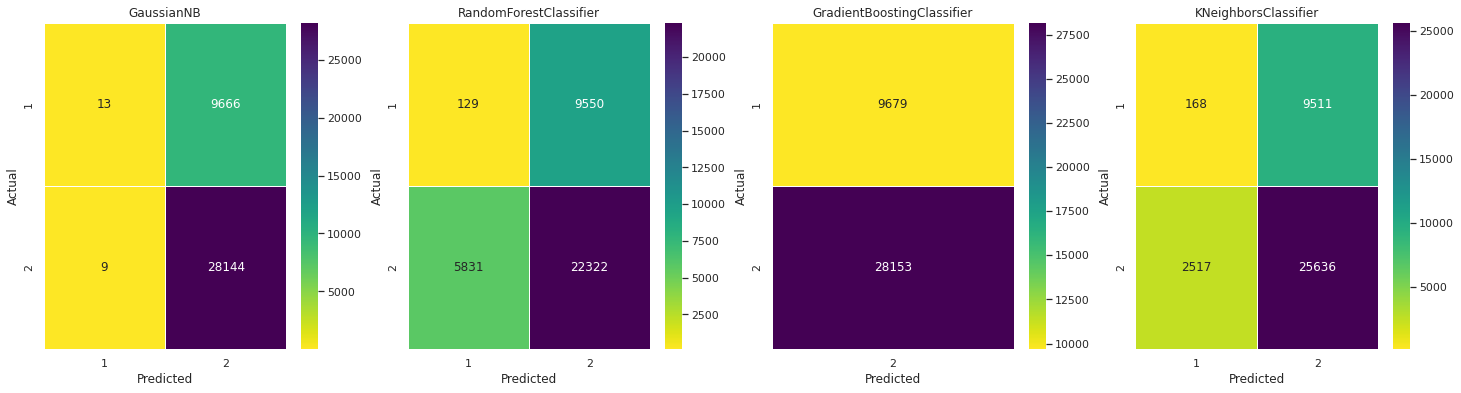

In [55]:
plot_confusion(models, X_test, y_test)

As seen from the above, all the considered models favors a prediction of an uncompleted offer.

The best scoring model compared to the base model of gaussian naive bayes from the above analysis is the KNeighborsClassifier. I will use Grid search to fine tune this model.

### Model Improvement

In [56]:
params={
    'n_neighbors':[5, 7, 9],
    'weights':['uniform', 'distance']
}
cv=GridSearchCV(model_knn,
               param_grid=params,
               n_jobs=-1,
               cv=10,
               verbose=5)

In [57]:
# fit the cv model
cv.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 7, 9],
                         'weights': ['uniform', 'distance']},
             verbose=5)

In [58]:
cv.best_estimator_

KNeighborsClassifier(n_neighbors=9)

In [59]:
print_report([cv], X_train, y_train, X_test, y_test)

GridSearchCV
--------------------
Train Report
              precision    recall  f1-score   support

           1       0.53      0.03      0.06     22753
           2       0.75      0.99      0.85     65521

    accuracy                           0.74     88274
   macro avg       0.64      0.51      0.45     88274
weighted avg       0.69      0.74      0.65     88274

Test Report
              precision    recall  f1-score   support

           1       0.09      0.01      0.02      9679
           2       0.74      0.97      0.84     28153

    accuracy                           0.73     37832
   macro avg       0.42      0.49      0.43     37832
weighted avg       0.57      0.73      0.63     37832

--------------------



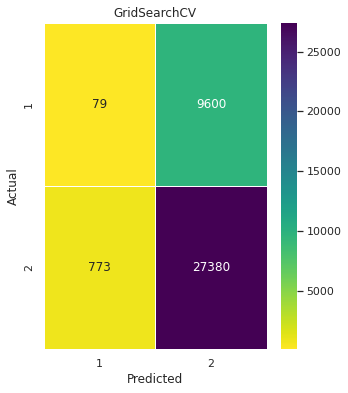

In [60]:
plot_confusion([cv], X_test, y_test, size=(5, 6))

There is an improvement in the model as the accuracy as now increased from `0.68` to `0.73` on the test dataset.

### Conclusion

The following conclusions can be drawn from the analysis of this dataset which is also inline with the model predictions.
1. Most customers do not show interest in the offers at all as it seems most people would rather buy than take advantage of the offer.
2. Seen as most offers sent to the male customers and those between the age bracket of 40 to 80 years were not completed, the company should target more people outside of this category for offers if they want more offers completed.

### Improvements

There were no parts of this analysis i found particularly challenging but i believe the modelling and analysis can be better improved by considering what was said in the conclusion as this would also represents a higher percentage of the general populace and hence introduce more variability into the dataset.